In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jaxopt import ScipyMinimize
import passenger

In [2]:
counts_path = "output/igh_counts_by_base.csv"
output_prefix = "chigy_hc"
nt_base_start = 0
chigy_stop_trimmed = passenger.CHIGY_HC_STOP_TRIMMED
output_dir = "output/"
output_path_prefix = output_dir+output_prefix

# These are positions with lots of Ns
# problem_positions = np.array([137, 154, 166])
# These are positions that didn't see any mutations in any passenger mouse.
problem_positions = np.array([0, 1, 306])

In [3]:
padded_seq = "NN" + chigy_stop_trimmed + "NN"

fivemers = [padded_seq[i:i+5] for i in range(len(padded_seq) - 4)]
complete_df = pd.DataFrame({"Fivemer": fivemers})

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')
mutability_series = mutability.set_index('Fivemer')['Mutability']
complete_df['Mutability'] = complete_df['Fivemer'].map(mutability_series)
n_frequency_df = pd.read_csv("output/igh_n_frequency.csv")
complete_df["N_frequency"] = n_frequency_df["N_frequency"]

counts_by_base = pd.read_csv(counts_path)

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')
mutability_series = mutability.set_index('Fivemer')['Mutability']

complete_df['Mutability'] = complete_df['Fivemer'].map(mutability_series)

## Combining information across the three experiments

### Substitution

Because the substitution matrix is simply a categorical on bases conditioned on a substitution, we don't have to worry about varying mutation load between the data sets.

In [4]:
by_base_dfs = dict(list(counts_by_base.groupby("nickname")))
for df in by_base_dfs.values():
    df.drop(columns=["nickname"], inplace=True)
    df.set_index("position", inplace=True)
    df.replace(-1, float("nan"), inplace=True)
    assert df.min().min() >= 0

In [5]:
pseudocount = 0.5

# total these dfs
by_base_df = sum(df for df in by_base_dfs.values())

by_base_df += pseudocount
# replace all nans by 0
by_base_df = by_base_df.fillna(0)
by_base_df = by_base_df.div(by_base_df.sum(axis=1), axis=0)
by_base_df.to_csv(output_path_prefix+"_substitution.csv")
by_base_df

,A,C,G,T
position,,,,
0,0.333333,0.333333,0.000000,0.333333
1,0.000000,0.333333,0.333333,0.333333
2,0.644013,0.307443,0.000000,0.048544
3,0.165049,0.747573,0.000000,0.087379
4,0.616580,0.212435,0.170984,0.000000
...,...,...,...,...
332,0.142857,0.000000,0.174603,0.682540
333,0.010526,0.326316,0.663158,0.000000
334,0.034483,0.000000,0.448276,0.517241


### Mutability

Let $i$ index the sites, and $j$ represent the experiment.
We will use the notation:

* $n_{ij}$: the number of mutations observed at site $i$ in experiment $j$
* $r_i$: the rate of mutation at site $i$
* $\lambda_j$: the Poisson offset for experiment $j$ representing the length of the period of affinity maturation
* $s_j$: the sequencing depth of experiment $j$

We will model

$$
n_{ij} \sim \operatorname{Pois}(r_i \lambda_j s_j)
$$

The log likelihood for this model across all sites and experiments will be 

$$
C + \sum_{i,j} \left[n_{ij} \log(r_i \lambda_j s_j) - r_i \lambda_j s_j \right]
$$

In [6]:
by_site_df = pd.DataFrame({name: df.sum(axis=1, skipna=True) for name, df in by_base_dfs.items()})
by_site_df

,5_IgG,5_IgM,6_IgG,6_IgM,7_IgG,7_IgM
position,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,18.0,48.0,15.0,21.0,15.0,36.0
3,2.0,17.0,1.0,14.0,0.0,16.0
4,14.0,35.0,0.0,21.0,5.0,20.0
...,...,...,...,...,...,...
332,2.0,6.0,2.0,8.0,2.0,10.0
333,7.0,13.0,7.0,11.0,1.0,7.0
334,2.0,5.0,1.0,2.0,0.0,3.0


In [7]:
read_counts_df = pd.read_csv("output/igh_read_counts.csv")
assert (read_counts_df["nickname"] == by_site_df.columns).all()
read_counts_df

,nickname,read_count
0,5_IgG,4728
1,5_IgM,9744
2,6_IgG,3451
3,6_IgM,7272
4,7_IgG,2216
5,7_IgM,7352


In [8]:
read_counts = jnp.array(read_counts_df["read_count"])
site_count = by_site_df.shape[0]
experiment_count = by_site_df.shape[1]

def neg_log_likelihood(params, n_ij, s_j):
    log_r_i, log_lambda_j = params[:site_count], params[site_count:]
    lambda_j = jnp.exp(log_lambda_j)
    r_i = jax.nn.softmax(log_r_i)
    expected = r_i[:, None] * lambda_j[None, :] * s_j[None, :]
    ll = n_ij * jnp.log(expected) - expected
    return -jnp.sum(ll)

n_ij = jnp.array(by_site_df)
initial_params = jnp.log(jnp.ones(site_count + experiment_count))

neg_log_likelihood(initial_params, n_ij, read_counts)

Array(-166619.9079125, dtype=float64)

In [9]:
# Set up the optimizer
optimizer = ScipyMinimize(fun=neg_log_likelihood, method='BFGS')
result = optimizer.run(initial_params, n_ij=n_ij, s_j=read_counts)

# Extract the optimized parameters
opt_params = result.params
r_i_opt = jax.nn.softmax(opt_params[:site_count])
lambda_j_opt = jnp.exp(opt_params[site_count:])

opt_likelihood = neg_log_likelihood(opt_params, n_ij, read_counts)

complete_df["fit_rate"] = r_i_opt

pd.DataFrame({"nickname": read_counts_df["nickname"], "mutation_load": lambda_j_opt})

,nickname,mutation_load
0,5_IgG,1.763748
1,5_IgM,2.109298
2,6_IgG,1.815706
3,6_IgM,1.888614
4,7_IgG,1.820848
5,7_IgM,2.022987


In [10]:
by_site_df.loc[complete_df['fit_rate'] <= 1e-10]

,5_IgG,5_IgM,6_IgG,6_IgM,7_IgG,7_IgM
position,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
306,0.0,0.0,0.0,0.0,0.0,0.0


## Correcting problem positions

### Substitution probabilities

In [11]:
fivemer_subs = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=' ')

fivemer_subs.set_index('Fivemer', inplace=True)

fivemer_subs = fivemer_subs.loc[complete_df['Fivemer']].reset_index()

fivemer_subs

,Fivemer,A,C,G,T
0,NNGAG,0.819555,0.074845,0.000000,0.105599
1,NGAGG,0.000000,0.242067,0.637422,0.120511
2,GAGGT,0.821029,0.102908,0.000000,0.076063
3,AGGTG,0.760705,0.113350,0.000000,0.125945
4,GGTGC,0.297297,0.513514,0.189189,0.000000
...,...,...,...,...,...
332,TCCTC,0.111111,0.000000,0.055556,0.833333
333,CCTCA,0.159851,0.650558,0.189591,0.000000
334,CTCAG,0.176471,0.000000,0.029412,0.794118
335,TCAGN,0.000000,0.145413,0.528597,0.325990


In [12]:
# for every index in problem_positions, get the A, C, G, T columns from fivemer_subs and replace the corresponding columns of df with them
for i in problem_positions:
    by_base_df.iloc[i, :] = fivemer_subs.iloc[i, 1:]
    
by_base_df

,A,C,G,T
position,,,,
0,0.819555,0.074845,0.000000,0.105599
1,0.000000,0.242067,0.637422,0.120511
2,0.644013,0.307443,0.000000,0.048544
3,0.165049,0.747573,0.000000,0.087379
4,0.616580,0.212435,0.170984,0.000000
...,...,...,...,...
332,0.142857,0.000000,0.174603,0.682540
333,0.010526,0.326316,0.663158,0.000000
334,0.034483,0.000000,0.448276,0.517241


### Mutability

In [13]:
# set the rate of the problematic positions to nan
complete_df.loc[problem_positions, "fit_rate"] = np.nan
# sum of df["fit_rate"], ignoring nan values
fit_rate_sum = complete_df["fit_rate"].sum(skipna=True)
complete_df["rate"] = complete_df["fit_rate"]/fit_rate_sum
complete_df["normed_s5f"] = complete_df["Mutability"] / sum(complete_df["Mutability"])

complete_df.loc[problem_positions, "rate"] = complete_df.loc[problem_positions, "normed_s5f"]

complete_df

,Fivemer,Mutability,N_frequency,fit_rate,rate,normed_s5f
0,NNGAG,0.000555,0.000000,NaN,0.001851,0.001851
1,NGAGG,0.000506,0.000000,NaN,0.001690,0.001690
2,GAGGT,0.000578,0.000403,0.002257,0.002257,0.001930
3,AGGTG,0.002178,0.000805,0.000737,0.000737,0.007267
4,GGTGC,0.000110,0.000460,0.001401,0.001401,0.000368
...,...,...,...,...,...,...
332,TCCTC,0.000950,0.000115,0.000442,0.000442,0.003168
333,CCTCA,0.000071,0.000604,0.000678,0.000678,0.000237
334,CTCAG,0.000572,0.000201,0.000192,0.000192,0.001909
335,TCAGN,0.000289,0.000173,0.000737,0.000737,0.000963


In [14]:
complete_df = pd.concat([complete_df, by_base_df * complete_df["rate"].values[:, None]], axis=1)
complete_df.index = complete_df.index + nt_base_start
complete_df

,Fivemer,Mutability,N_frequency,fit_rate,rate,normed_s5f,A,C,G,T
0,NNGAG,0.000555,0.000000,NaN,0.001851,0.001851,0.001517,0.000139,0.000000,0.000195
1,NGAGG,0.000506,0.000000,NaN,0.001690,0.001690,0.000000,0.000409,0.001077,0.000204
2,GAGGT,0.000578,0.000403,0.002257,0.002257,0.001930,0.001453,0.000694,0.000000,0.000110
3,AGGTG,0.002178,0.000805,0.000737,0.000737,0.007267,0.000122,0.000551,0.000000,0.000064
4,GGTGC,0.000110,0.000460,0.001401,0.001401,0.000368,0.000864,0.000298,0.000240,0.000000
...,...,...,...,...,...,...,...,...,...,...
332,TCCTC,0.000950,0.000115,0.000442,0.000442,0.003168,0.000063,0.000000,0.000077,0.000302
333,CCTCA,0.000071,0.000604,0.000678,0.000678,0.000237,0.000007,0.000221,0.000450,0.000000
334,CTCAG,0.000572,0.000201,0.000192,0.000192,0.001909,0.000007,0.000000,0.000086,0.000099
335,TCAGN,0.000289,0.000173,0.000737,0.000737,0.000963,0.000000,0.000150,0.000322,0.000265


In [15]:
complete_df.to_csv(f"{output_path_prefix}_mutation_rates_nt.csv", columns=["Fivemer", "A", "C", "G", "T"])
complete_df.to_csv(f"{output_path_prefix}_mutation_rates_nt_extras.csv", columns=["Fivemer", "rate", "normed_s5f", "A", "C", "G", "T"])

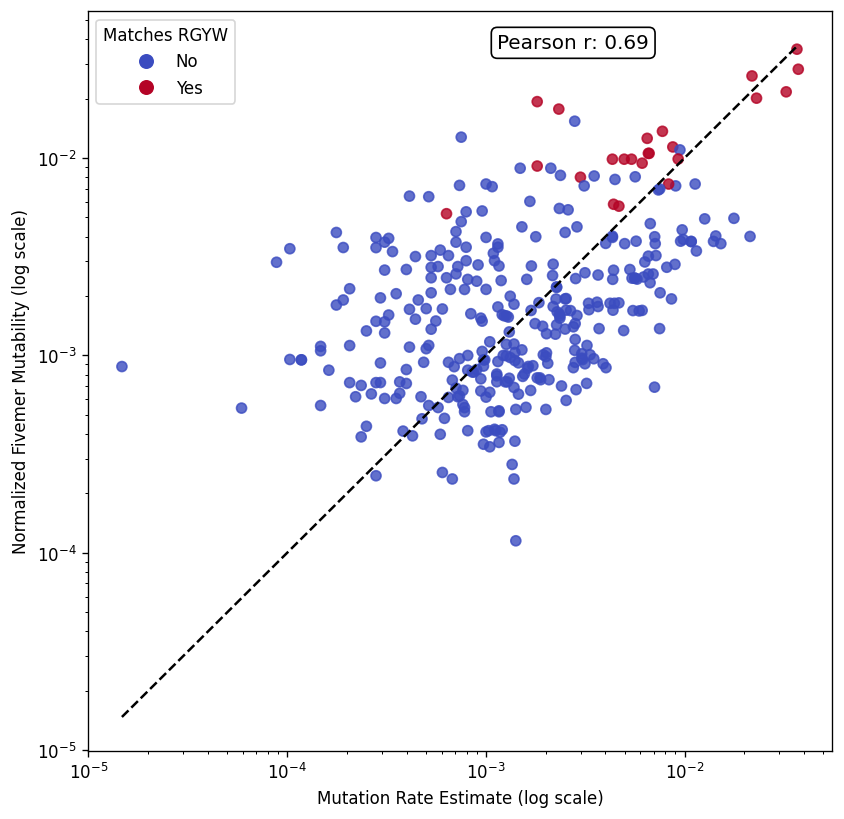

In [16]:
# Apply the matches_RGYW function to the 'Fivemer' column
complete_df['matches_RGYW'] = complete_df['Fivemer'].apply(passenger.matches_RGYW)

passenger.plot_mutation_rate_vs_normed_s5f(complete_df)

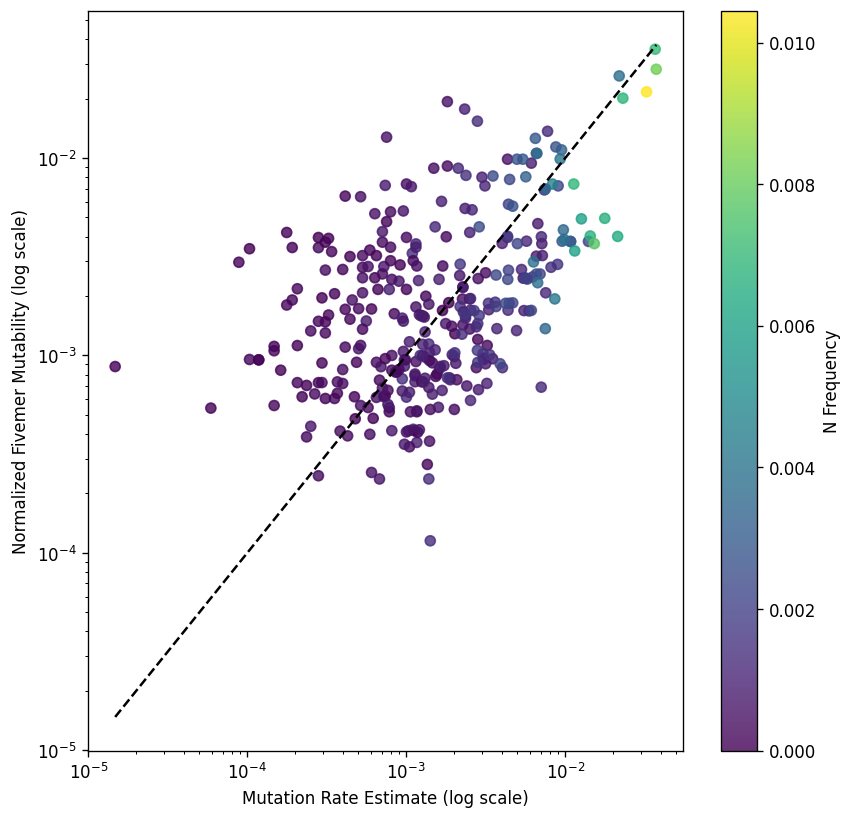

In [17]:
def plot_mutation_rate_vs_normed_s5f_showing_N(df):
    plt.figure(figsize=(8, 8))  # Square aspect ratio
    scatter = plt.scatter(
        df["rate"], df["normed_s5f"], c=df["N_frequency"], cmap="viridis", alpha=0.8
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Mutation Rate Estimate (log scale)")
    plt.ylabel("Normalized Fivemer Mutability (log scale)")

    # Add a color bar to the plot
    plt.colorbar(scatter, label="N Frequency")

    # Add y=x line
    min_limit = min(df["rate"].min(), df["normed_s5f"].min())
    max_limit = max(df["rate"].max(), df["normed_s5f"].max())
    plt.plot([min_limit, max_limit], [min_limit, max_limit], "k--")  # Add x=y line

    plt.show()

plot_mutation_rate_vs_normed_s5f_showing_N(complete_df)
